In [1]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
sns.set()

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from statsmodels.tsa.arima_model import ARIMA

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
data_min = pd.read_csv('data.csv', index_col=['timestamp'], parse_dates=['timestamp'])

In [3]:
data_min.head()

,value
timestamp,
2019-07-01 04:16:00,19
2019-07-01 04:15:00,11
2019-07-01 04:14:00,10
2019-07-01 04:13:00,10
2019-07-01 04:12:00,78


In [4]:
data = data_min.resample('H', how='mean')

In [5]:
data.head()

,value
timestamp,
2019-06-01 04:00:00,70.058824
2019-06-01 05:00:00,65.450000
2019-06-01 06:00:00,68.650000
2019-06-01 07:00:00,60.866667
2019-06-01 08:00:00,73.100000


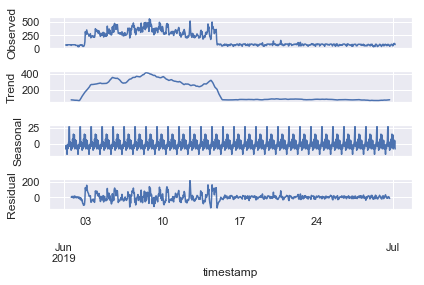

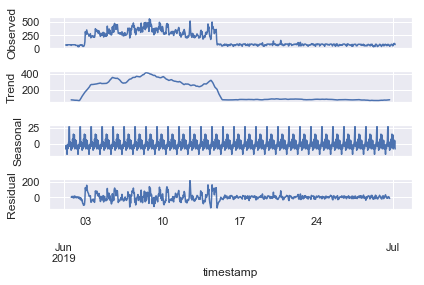

In [6]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(data.value, model='additive')
decomposition.plot()

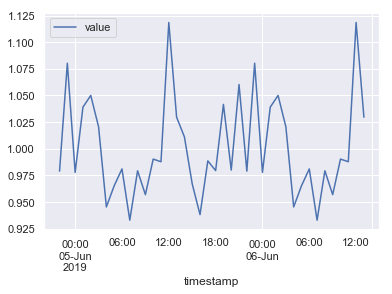

In [15]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(data, model='multiplicative')
decomposition.seasonal[90:130].plot()

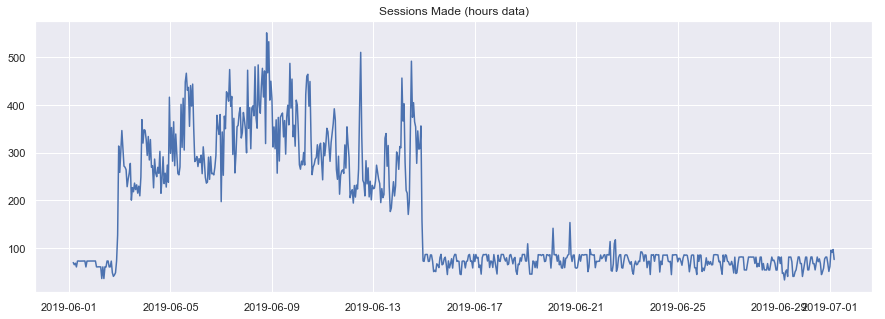

In [16]:
plt.figure(figsize=(15, 5))
plt.plot(data.value)
plt.title('Sessions Made (hours data)')
plt.grid(True)
plt.show()


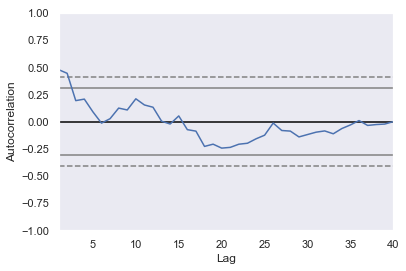

In [17]:
pd.plotting.autocorrelation_plot(data[:40]);

In [18]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(data, 30) # prediction for the last 30 minutes

70.68150326797385

In [19]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [20]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

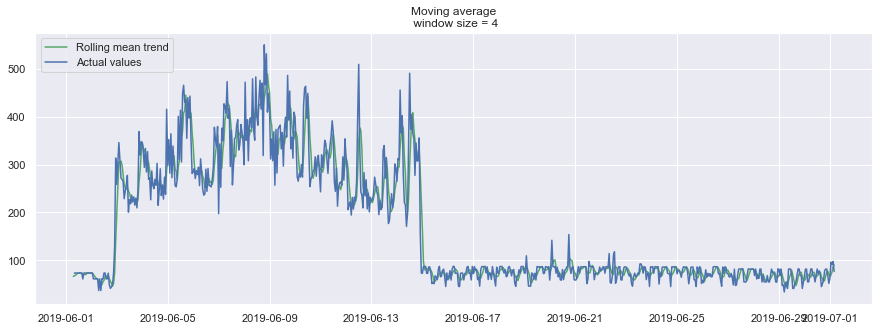

In [21]:
plotMovingAverage(data, 4) 

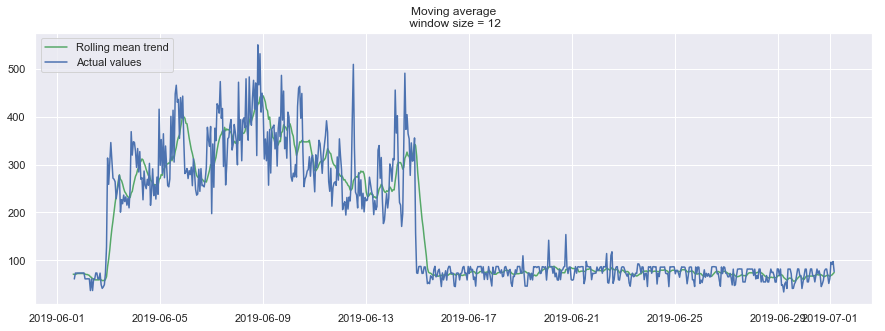

In [22]:
plotMovingAverage(data, 12) 

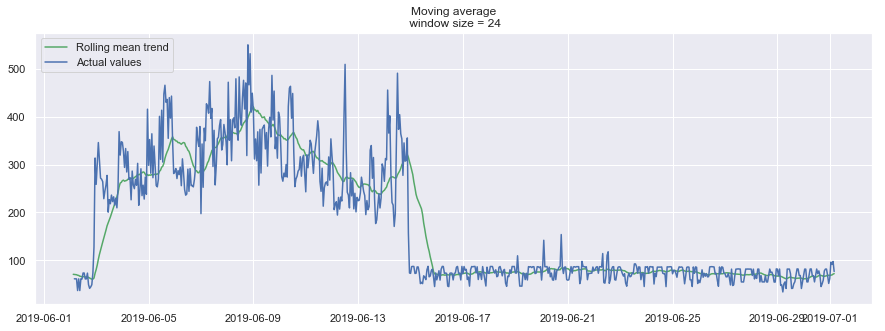

In [23]:
plotMovingAverage(data, 24)

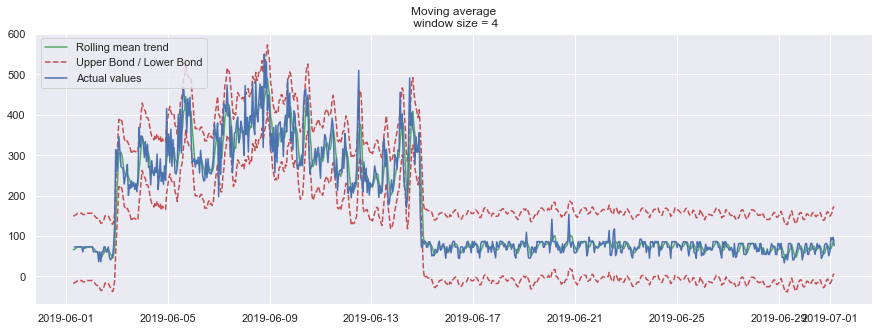

In [24]:
plotMovingAverage(data, 4, plot_intervals=True)


In [25]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [26]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True)

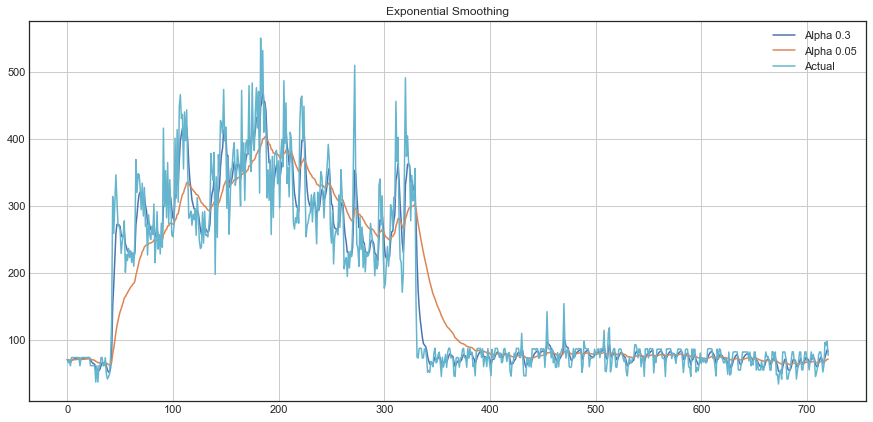

In [27]:
plotExponentialSmoothing(data.value, [0.3, 0.05])

In [28]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

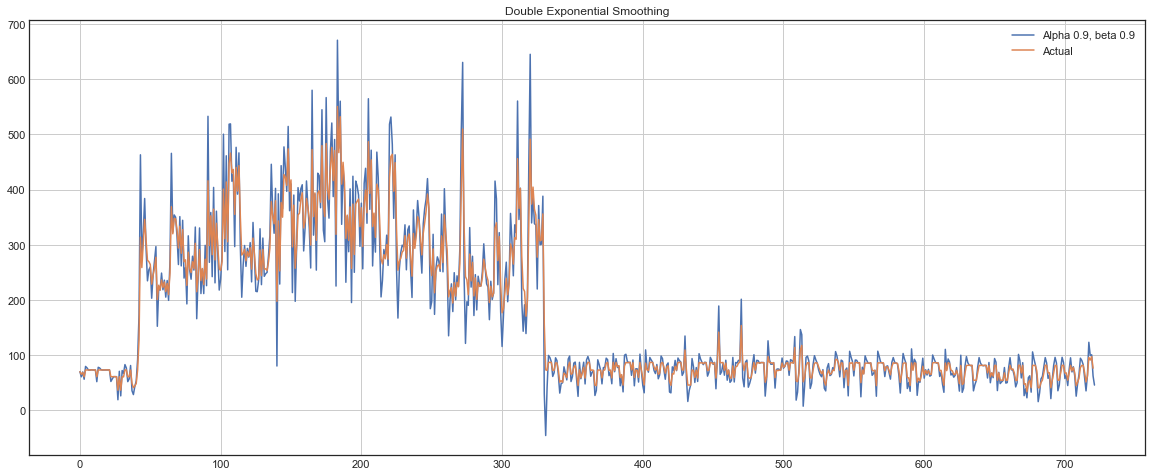

In [29]:
plotDoubleExponentialSmoothing(data.value, alphas=[0.9], betas=[0.9])


In [119]:
# from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

# def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
#     """
#         Returns error on CV  
        
#         params - vector of parameters for optimization
#         series - dataset with timeseries
#         slen - season length for Holt-Winters model
#     """
#     # errors array
#     errors = []
    
#     values = series.values
#     alpha, beta = params
    
#     # set the number of folds for cross-validation
#     tscv = TimeSeriesSplit(n_splits=3) 
    
#     # iterating over folds, train model on each, forecast and calculate error
#     for train, test in tscv.split(values):
#         model = double_exponential_smoothing(values, alpha, beta)

#         predictions = model[-len(test):]
#         actual = values[test]
        
#         error = loss_function(predictions, actual)
#         errors.append(error)
        
#     return np.mean(np.array(errors))

In [120]:
# %%time
# data_test = data[:-20] # leave some data for testing

# # initializing model parameters alpha, beta 
# x = [0, 0] 

# # Minimizing the loss function 
# opt = minimize(timeseriesCVscore, x0=x, 
#                args=(data, mean_squared_error), 
#                method="TNC", bounds = ((0, 1), (0, 1))
#               )

# # Take optimal values...
# print(opt.x)
# alpha_final, beta_final = opt.x
# print(alpha_final, beta_final)
# alpha_final, beta_final = 0.9,0.9
# # ...and train the model with them, forecasting for the next 50 hours
# plotDoubleExponentialSmoothing(data_test.value, alphas=[alpha_final], betas=[beta_final])

In [30]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

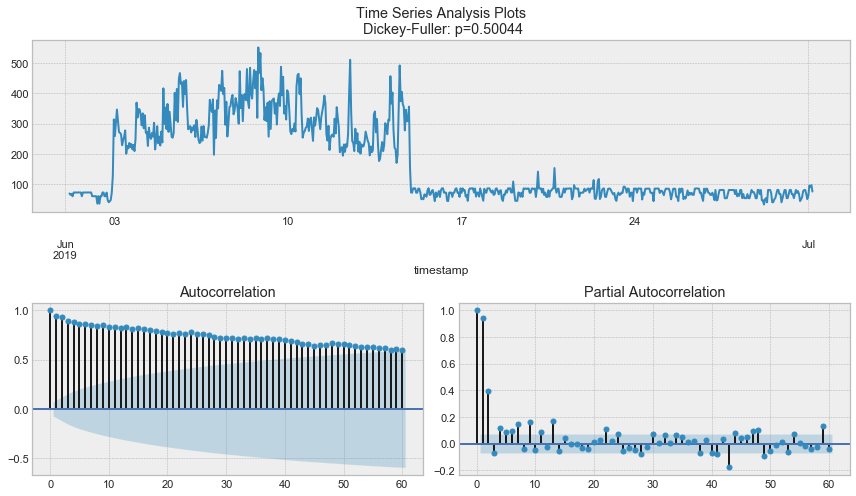

In [31]:
tsplot(data.value, lags=60)


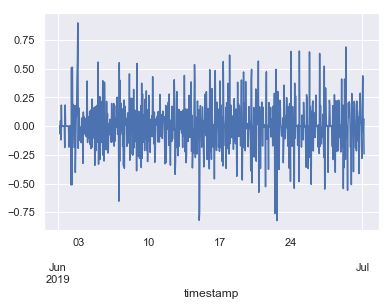

In [32]:
data['value_log'] = np.log(data['value'])
data['value_diff'] = data['value_log'] - data['value_log'].shift(1)
# data.replace([np.inf, -np.inf], np.nan)
# data['value_diff'] = data['value_diff'].dropna()
data['value_diff'] = data['value_diff'].replace([np.inf, -np.inf], np.nan).fillna(0)
data['value_diff'].plot()


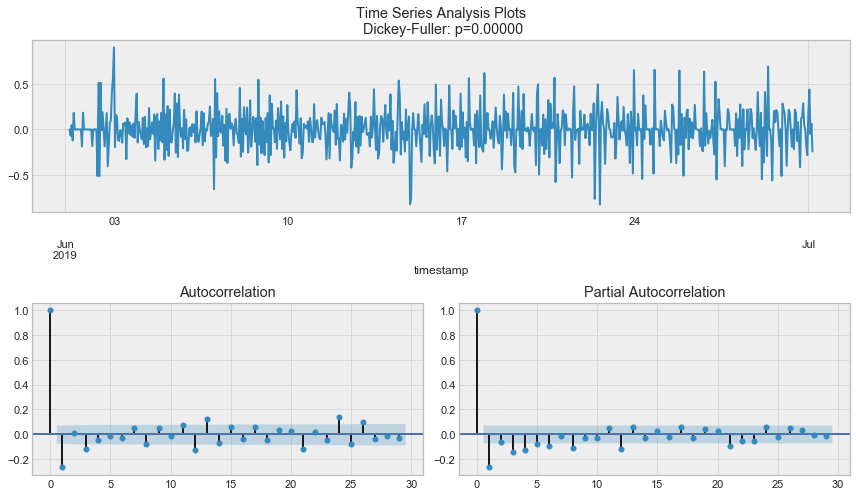

In [33]:
tsplot(data.value_diff)

In [34]:
# setting initial values and some bounds for them
ps = range(1, 4)
d=1 
qs = range(1, 4)
Ps = range(1, 2)
D=1 
Qs = range(1, 2)
s = 12 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

9

In [37]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")
    print(len(parameters_list))
    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
#             print(data.value_diff.size)
            model=sm.tsa.statespace.SARIMAX(data.value, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
            print(param)
#             model=ARIMA(data.value, order=(param[0], d, param[1])).fit(disp=-1)
        except Exception as e:
            print(e)
            continue
        aic = model.aic
        # saving best model, AIC and parameters
#         print(aic)
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    print(result_table.head())
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [38]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

9


(1, 1, 1, 1)
(1, 2, 1, 1)
(1, 3, 1, 1)
(2, 1, 1, 1)
(2, 2, 1, 1)
(2, 3, 1, 1)
(3, 1, 1, 1)
(3, 2, 1, 1)
(3, 3, 1, 1)
              0            1
0  (1, 1, 1, 1)  7264.958332
1  (1, 2, 1, 1)  7259.126622
2  (1, 3, 1, 1)  7233.387977
3  (2, 1, 1, 1)  7266.116680
4  (2, 2, 1, 1)  7236.138927
CPU times: user 1min 13s, sys: 6.61 s, total: 1min 19s
Wall time: 1min 17s


In [39]:
result_table.head()


,parameters,aic
0,"(3, 3, 1, 1)",7201.519192
1,"(3, 2, 1, 1)",7229.247901
2,"(3, 1, 1, 1)",7231.398562
3,"(1, 3, 1, 1)",7233.387977
4,"(2, 2, 1, 1)",7236.138927


In [41]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

# best_model=ARIMA(data.value, order=(p, d,q)).fit(disp=-1)
best_model=sm.tsa.statespace.SARIMAX(data.value, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  721
Model:             SARIMAX(3, 1, 3)x(1, 1, 1, 12)   Log Likelihood               -3591.760
Date:                            Tue, 02 Jul 2019   AIC                           7201.519
Time:                                    00:55:33   BIC                           7242.581
Sample:                                06-01-2019   HQIC                          7217.384
                                     - 07-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1866      0.050    -23.843      0.000      -1.284      -1.089
ar.L2          0.3401      0.083   

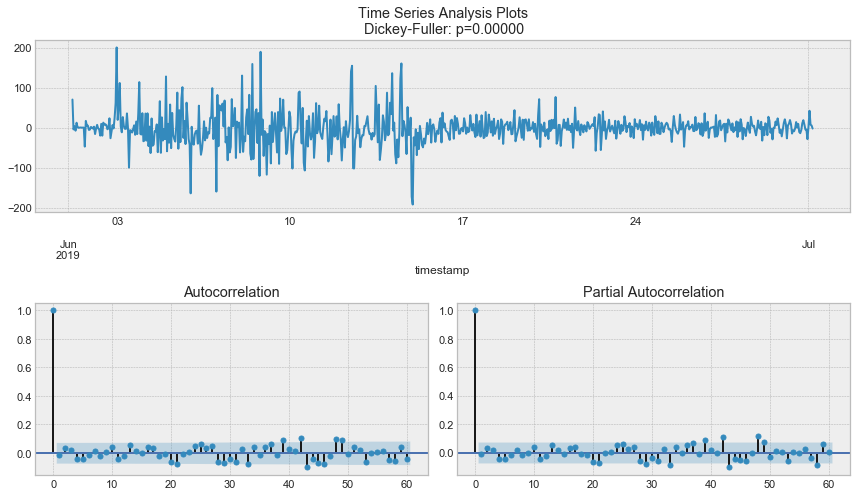

In [42]:
tsplot(best_model.resid, lags=60)

In [43]:
print(best_model.fittedvalues)

timestamp
2019-06-01 04:00:00      0.000000
2019-06-01 05:00:00     69.979456
2019-06-01 06:00:00     65.509267
2019-06-01 07:00:00     68.585799
2019-06-01 08:00:00     60.921326
2019-06-01 09:00:00     73.038389
2019-06-01 10:00:00     73.393783
2019-06-01 11:00:00     73.080420
2019-06-01 12:00:00     73.141861
2019-06-01 13:00:00     73.450789
2019-06-01 14:00:00     73.267487
2019-06-01 15:00:00     73.290901
2019-06-01 16:00:00    108.302253
2019-06-01 17:00:00     56.463667
2019-06-01 18:00:00     68.086252
2019-06-01 19:00:00     68.319813
2019-06-01 20:00:00     79.046863
2019-06-01 21:00:00     78.237614
2019-06-01 22:00:00     71.710712
2019-06-01 23:00:00     73.256206
2019-06-02 00:00:00     75.831772
2019-06-02 01:00:00     70.950898
2019-06-02 02:00:00     77.191604
2019-06-02 03:00:00     63.088438
2019-06-02 04:00:00     54.316688
2019-06-02 05:00:00     63.080614
2019-06-02 06:00:00     65.494489
2019-06-02 07:00:00     56.568670
2019-06-02 08:00:00     51.794940
2019

In [44]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    
#     data_temp = series.copy()
    data_temp = pd.DataFrame(series)
    
    data_temp.columns = ['value']
    data_temp['arima_model'] = model.fittedvalues
    print(data_temp.head())
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data_temp['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data_temp.shape[0], end = data_temp.shape[0]+n_steps)
    forecast = data_temp.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['value'][s+d:], data_temp['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data_temp.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data_temp.value, label="actual")
    plt.legend()
    plt.grid(True);

                         value  arima_model
timestamp                                  
2019-06-01 04:00:00  70.058824     0.000000
2019-06-01 05:00:00  65.450000    69.979456
2019-06-01 06:00:00  68.650000    65.509267
2019-06-01 07:00:00  60.866667    68.585799
2019-06-01 08:00:00  73.100000    60.921326


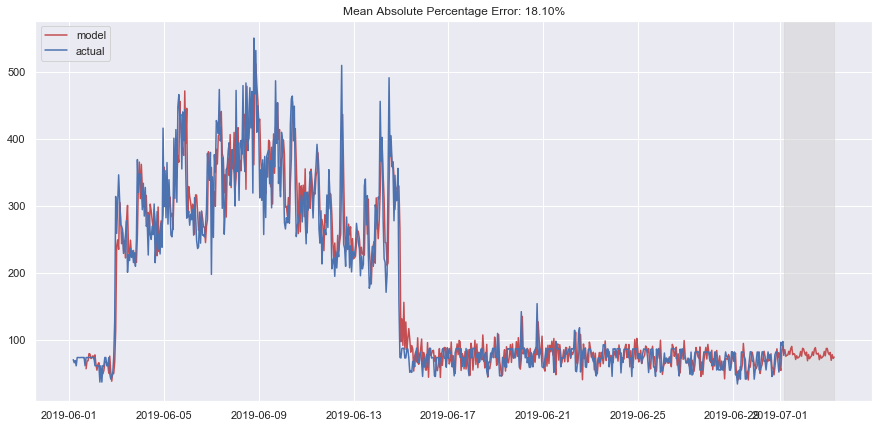

In [46]:

plotSARIMA(data.value, best_model, 50)
